# **Multiple Linear Regression of the Dataset "cacao.csv"**

## **Installing and Loading Libraries**

Firstly we need to import different libraries that we use to perform the multiple linear regression and install them if not done yet:


In [1]:
# Install the newest version of pip

!python -m pip install --upgrade pip

In [78]:
# Install numpy, pandas and sklearn IF NOT INSTALLED

%pip install numpy >nul & pip install pandas >nul & pip install matplotlib >nul & pip install scikit-learn >nul & pip install seaborn >nul & pip install statsmodels >nul

Note: you may need to restart the kernel to use updated packages.


In [52]:
%reset -f

# Import libraries

import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import statsmodels
import statsmodels.api as sm  # type: ignore
import statsmodels.formula.api as smf # type: ignore
import statsmodels.stats.api as sms # type: ignore
import statsmodels.stats.diagnostic as smsd # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.linear_model import LinearRegression # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

## **Starting the Multiple Linear Regression**

### **Reading in the Data**

Firstly, we need to read our dataset into Python:

In [30]:
path = 'C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/Datasets/cacao.csv' # path to our dataset
df = pd.read_csv(path)

### **Variables of the Dataset**

In [31]:
col_names = df.columns.tolist()
total_num_of_var = len(col_names)-1

print("We have a total number of " + str(total_num_of_var) + " variables")
print("Those are presented in this list: " + str(col_names))

We have a total number of 12 variables
Those are presented in this list: ['ant_exclusion', 'stem_diameter', 'height', 'canopy', 'dw_healthy', 'dw_infect', 'dw_total', 'fw_pulb', 'fw_seeds', 'fw_total', 'ab_fl_op', 'ab_fl_cl', 'ab_fl']


### **'stem_diameter' as Dependend Variable**
We decided, that we want to perform a multiple linear regression using stem_diameter as y and all the other variables as predictors.

In [33]:
dependend_var = 'stem_diameter'
y = df[dependend_var]
x = df.drop(dependend_var, axis=1) # axis = 1 to look at columns instead of rows

Now we have to split out data into a training dataset and a test dataset.

The model will be trained by the trainings dataset

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.3, random_state=0)

# add a constant to include the intercept in the model

x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

model = sm.OLS(y_train, x_train).fit()

Let's see how good the model is when all predictors are included

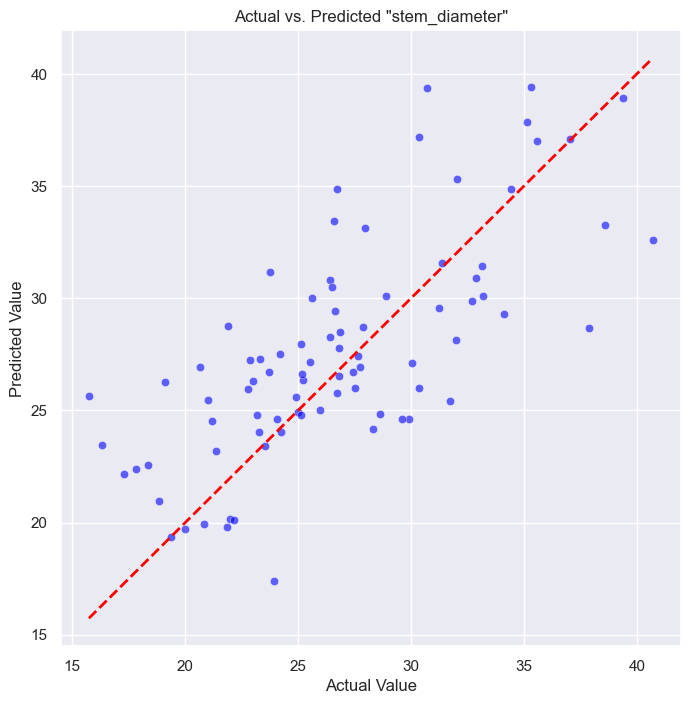

In [38]:

# Test the model

y_test_pred = model.predict(x_test)
pred_values = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Plot actual value vs predicted value


sns.set_theme("notebook")
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=pred_values, color="blue", alpha=0.6)
plt.plot([pred_values['Actual'].min(), pred_values['Actual'].max()], 
         [pred_values['Actual'].min(), pred_values['Actual'].max()], 
         color='red', lw=2, linestyle='--')  # line for perfect predictions
plt.title('Actual vs. Predicted "stem_diameter"')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.grid(True)
plt.show()

In [39]:
r2_score(y_test, y_test_pred)

0.46011433469954854

Because the models r2 score is only 0.46 we can say, that the model is not that good. But how can we improve the model?

## **Diagnostics Plots**

In order to check for linearity, homoscedacity, independancy and normal distribution we will use diagnostics.

We have do define the LinearRegDiagnostic-class (https://www.statsmodels.org/dev/examples/notebooks/generated/linear_regression_diagnostics_plots.html)

In [41]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-v0_8-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-v0_8-paper', **kwargs):
        # print(plt.style.available)
        # GH#9157
        if plot_context not in plt.style.available:
            plot_context = 'default'
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y



After we optimized our model we want to check the assumptions of the model by using the defined regression diagnostics.

In [42]:
cls = LinearRegDiagnostic(model)

### **Residual vs Fitted Values**

Graphical tool to identify non-linearity.

In the graph red (roughly) horizontal line is an indicator that the residual has a linear pattern.

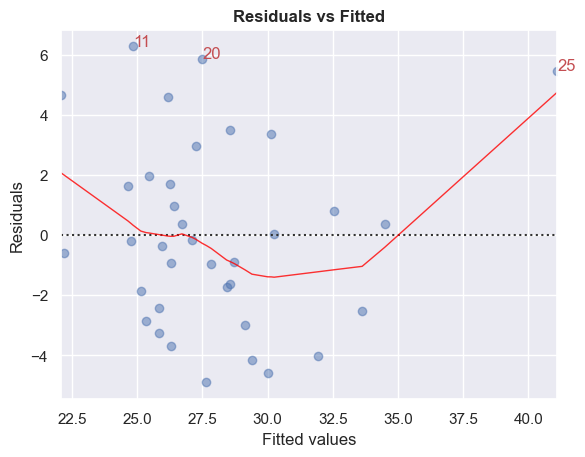

In [43]:
cls.residual_plot();

### **Standarized Residual cs Theoretical Quantile**

This plot is used to visually check if residuals are normally distributed.

Points spread along the diagonal line will suggest so.

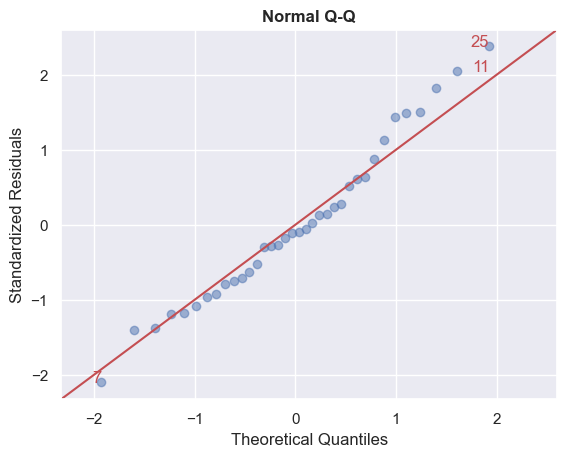

In [44]:
cls.qq_plot();

### **Standarized Residuals vs Fitted Values**

This plot is used to check homoscedasticity of the residuals.

A near horizontal red line in the graph would suggest so.

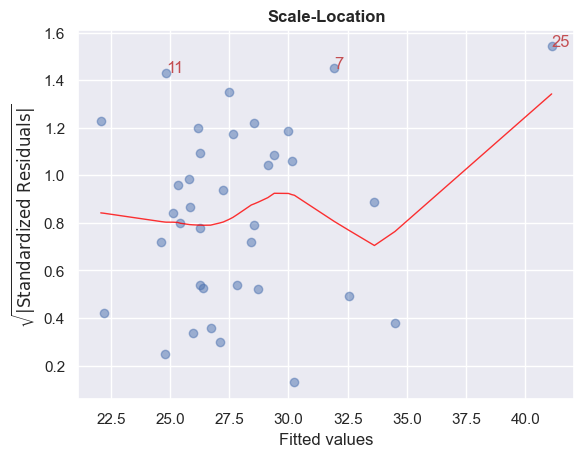

In [45]:

cls.scale_location_plot();

### **Residual vs Leverage**

Points falling outside the Cook’s distance curves are considered observation that can sway the fit aka are influential.

Good to have no points outside these curves.

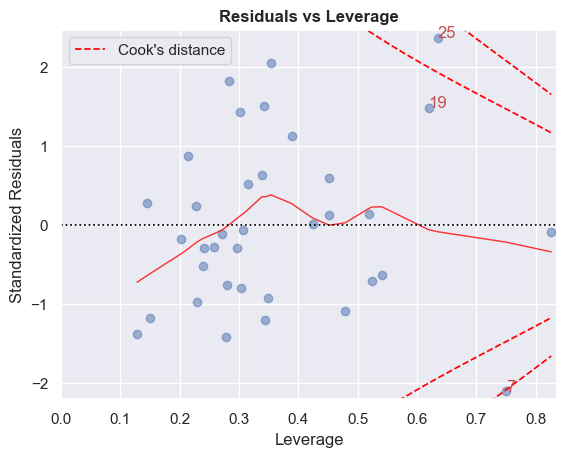

In [46]:
cls.leverage_plot();

### **VIF**

The variance inflation factor (VIF), is a measure of multicollinearity.

VIF > 5 for a variable indicates that it is highly collinear with the other input variables.

In [47]:
vif_table_out = cls.vif_table();
vif_table_out

,Features,VIF Factor
2,height,1.53
3,canopy,1.65
1,ant_exclusion,1.89
0,const,207.85
10,ab_fl_op,227.13
8,fw_seeds,342.40
11,ab_fl_cl,1359.64
5,dw_infect,1712.65
7,fw_pulb,2146.49
12,ab_fl,2484.27


We can suggest, that the variables height, canopy and ant_exclusion are likely to be not highly collinear with the other input variables.

## **Interpretation of Plots**

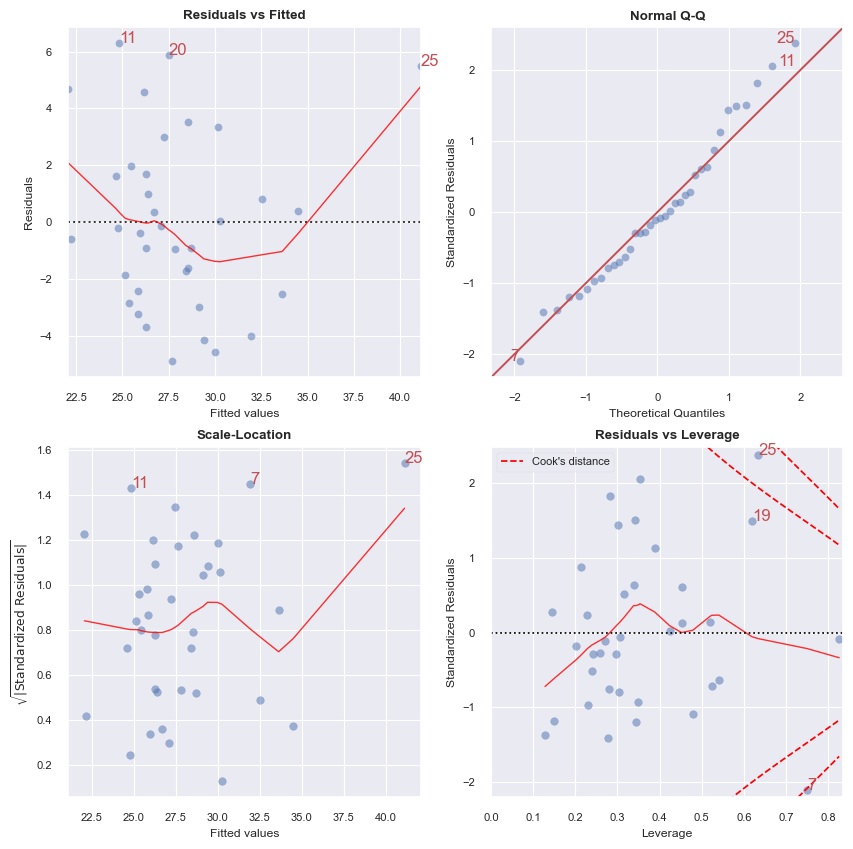

In [49]:
vif, fig, ax = cls()
fig.savefig('C:/Users/phleu/linear_regression_diagnostics_plots.png')

**Residual vs Fitted**

The red curve in this plot implies that the linearity assumption is violated. When this assumption is not violated, the red line should be mainly a straigt line around 0. In order to solve this problem a transformation of the variables might help. It appears that point 25 distort the linearity assumption, which should be checked for outliers.

**Normal Q-Q**

The points are mostly around the bisector, so we can suggest, that the normality of residuals are not violated, but the outliers should be investigated.

**Scale-Location**

The points should be randomly distributed around a horizontal line. The pattern in the plot suggests potential homoscedasticity, but a transformation of the dependent variable might be useful.

**Residuals vs Leverage**

Points with high leverage and large residuals (which might be outside the dotted Cook's distance lines) are potentially influential. Some points have a high leverage and significant residuals, indicating they could strongly influence the model. Those points should be further examined to determine if they are valid data points or anomalies.

## **Diagnostics Statistical Tests**

In many cases of statistical analysis, we are not sure whether our statistical model is correctly specified. For example when using ols, then linearity and homoscedasticity are assumed, some test statistics additionally assume that the errors are normally distributed or that we have a large sample. Since our results depend on these statistical assumptions, the results are only correct of our assumptions hold (at least approximately). The following briefly summarizes specification and diagnostics tests for linear regression.

### **Heteroscedasticity Test - Lagrange Multiplier Heteroscedasticity Test by Breusch-Pagan**

For these test the null hypothesis is that all observations have the same error variance, i.e. errors are homoscedastic. The tests differ in which kind of heteroscedasticity is considered as alternative hypothesis. They also vary in the power of the test for different types of heteroscedasticity.

In [50]:
test_result = sms.het_breuschpagan(model.resid, model.model.exog)

# H0: The variance of the residuals is constant (homoscedasticity).
# H1: The variance of the residuals is not constant (heteroscedasticity)
# Refuse H0, if p-value < 0.05
# Don't refuse H0, if p-value >= 0.05

# Output the results
bp_test_stat = test_result[0]
bp_test_pvalue = test_result[1]
print(f'Breusch-Pagan test statistic: {bp_test_stat}')
print(f'Breusch-Pagan p-value: {bp_test_pvalue}')

Breusch-Pagan test statistic: 9.324329525030494
Breusch-Pagan p-value: 0.6750070820527372


The p-value of 0.675 indicates that the residuals of the model are likely homoscedastic, meaning that their variance is constant across different levels of the independent variables.

### **Autocorrelation Test - Breusch-Pagan Test for No Autocorrelation of Residuals**

This test whether the regression residuals are not autocorrelated. They assume that observations are ordered by time.

In [53]:
test_result = smsd.acorr_breusch_godfrey(model, nlags=1)

# H0: There is no serial correlation in the residuals.
# H1: There is serial correlation in the residuals.

# Output the results
bg_test_stat = test_result[0]
bg_test_pvalue = test_result[1]
print(f'Breusch-Godfrey test statistic: {bg_test_stat}')
print(f'Breusch-Godfrey p-value: {bg_test_pvalue}')

Breusch-Godfrey test statistic: 0.9017826021458513
Breusch-Godfrey p-value: 0.3423041793088934


No Evidence of Serial Correlation: The p-value of 0.34 suggests that there is no significant evidence of serial correlation in the residuals of your regression model. In other words, the residuals appear to be independent of each other.

### **Non-Linearity Test - Harvey-Collier Test**

In [74]:
test_stat, p_value = smsd.linear_harvey_collier(model)

# Output the results
print(f'Harvey-Collier test statistic: {test_stat}')
print(f'Harvey-Collier test p-value: {p_value}')

Harvey-Collier test statistic: nan
Harvey-Collier test p-value: nan


Multicollinarity can cause issues, what might be the case here.

### **Tests for Structural Change, Parameter Stability (Unknown Change Points)**

Test whether all or some regression coefficient are constant over the entire data sample.

In [75]:
test_stat, p_value = smsd.breaks_cusumolsresid(model.resid)

# Output the results
print(f'CUSUM test statistic: {test_stat}')
print(f'CUSUM test p-value: {p_value}')

ValueError: too many values to unpack (expected 2)

Doesn't work???

### **Normality and Distribution Tests**

In [76]:
test_stat, p_value = sms.normal_ad(df)

# Output the results
print(f'Anderson-Darling test statistic: {test_stat}')
print(f'Anderson-Darling test p-value: {p_value}')

Anderson-Darling test statistic: [21.39204916  0.80770814  0.86944595  0.7603833   1.68565462  4.29008531
  1.28927589  1.29937142  1.26183861  1.19038385  2.02433748  2.30287958
  2.27892219]
Anderson-Darling test p-value: [8.45283670e-50 3.56232827e-02 2.50339021e-02 4.66890525e-02
 2.39292906e-04 1.01743158e-10 2.28220277e-03 2.15465112e-03
 2.66836349e-03 4.00968583e-03 3.50029614e-05 7.22650542e-06
 8.27580810e-06]


Those p-values sugggest that the data don't follow a normal distribution.

### **Outlier and Influence Diagnostic Measures**

These measures try to identify observations that are outliers, with large residual, or observations that have a large influence on the regression estimates. Robust Regression, RLM, can be used to both estimate in an outlier robust way as well as identify outlier. The advantage of RLM that the estimation results are not strongly influenced even if there are many outliers, while most of the other measures are better in identifying individual outliers and might not be able to identify groups of outliers.

In [83]:
endog = y_train
exog = x_train
# Add a constant to the independent variables
exog = sm.add_constant(exog)

# Fit a robust linear model using Huber's T norm
huber_t = sm.RLM(endog, exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()

# Print the weights
print("Weights assigned by the robust linear model (Huber's T norm):")
print(hub_results.weights)

Weights assigned by the robust linear model (Huber's T norm):
49     1.000000
82     0.929531
116    1.000000
118    1.000000
79     0.938658
69     1.000000
80     1.000000
20     1.000000
112    1.000000
72     1.000000
77     1.000000
25     0.625047
37     1.000000
81     1.000000
105    1.000000
46     1.000000
108    1.000000
39     1.000000
65     1.000000
58     1.000000
12     0.658016
106    1.000000
88     1.000000
70     1.000000
87     1.000000
36     0.589151
21     1.000000
83     1.000000
9      1.000000
103    1.000000
115    0.889997
67     1.000000
64     0.914159
117    1.000000
47     1.000000
44     1.000000
dtype: float64


Since the points 12 and 25 are very far away from 1 we could consider those as outliers.

     dfb_const  dfb_ant_exclusion  dfb_height  dfb_canopy  dfb_dw_healthy  \
49   -0.099591           0.227994    0.053776    0.139225       -0.433860   
82    0.192023           0.025823   -0.245594    0.025377       -0.525963   
116   0.054236           0.073009   -0.061051   -0.032370       -0.026061   
118   0.028194           0.052645   -0.022558   -0.098339       -0.086087   
79   -0.351115           0.124111    0.253152    0.357040        0.337253   
69   -0.088348           0.047305    0.089112    0.063747        0.026235   
80    0.211780           0.080301   -0.250999   -0.085916       -0.066460   
20    0.360127           0.346059   -0.372359   -0.163578        1.025994   
112  -0.050681           0.051158    0.045859    0.053231       -0.018038   
72   -0.054680          -0.193384    0.077937    0.151588       -0.124513   
77   -0.011487           0.272915   -0.044897   -0.026753        0.009723   
25    0.765621           0.532142   -0.639735   -0.827892       -0.153513   

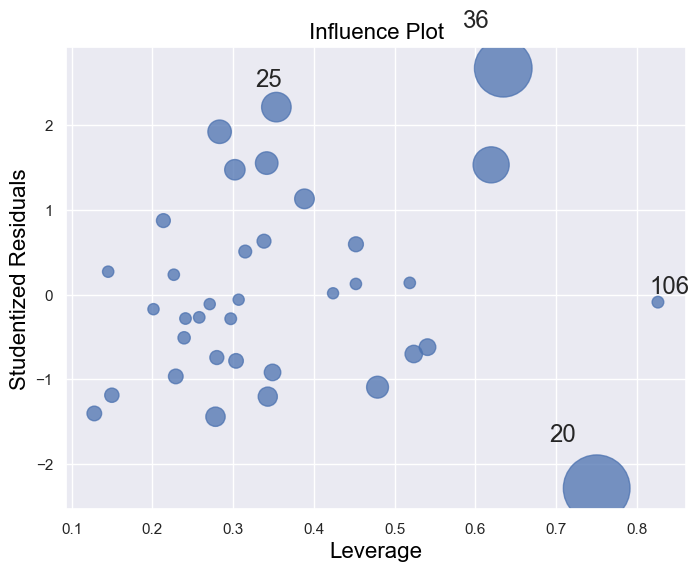

In [80]:
influence = model.get_influence()
summary_frame = influence.summary_frame()
print(summary_frame)

fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

plt.show()

We can see that point 25, 36, 106 and 20 are influential points.

All in all we see that point 25 is both an outlier and an influential point so we would suggest to exclude this point from the data. This might have an impact on the model.